## Code replicated from Syed's CellOT notebook.

In [1]:
# Standard Libraries
import os # operating system dependent functionality
from collections import Counter # counting elements in an iterable

# External Libraries
import numpy as np # numerical operations on data arrays and matrices
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # plotting and visualizations
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors

# Bioinformatics and Data Analysis 
import anndata # handling annotated data, particularly in genomics
import scanpy as sc # single-cell RNA-seq data analysis
import scipy # scientific and technical computations

# Test Specific Libraries
import os
import pickle
import random
from collections import Counter

import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

# Huggingface
import torch
from transformers import AutoModelForCausalLM
from datasets import load_from_disk

# Confusion Matrix visualization
from sklearn.metrics import confusion_matrix
from pandas import DataFrame
import seaborn as sns

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

In [3]:
orig_data_path = "/home/dor3/cell2sentence/cross_species/Syed_CellOT_Code/datasets/harmony_common_pancreas_20241025.h5ad"
BASE_PATH = "/home/dor3/cell2sentence/cross_species/CellOT_on_Homologous_Data/models/results_human_to_mouse/evals_iid_data_space"
cell_ot_transported_data_path = os.path.join(BASE_PATH, "imputed.h5ad")

In [4]:
orig_adata = anndata.read_h5ad(orig_data_path)
orig_adata

AnnData object with n_obs × n_vars = 9436 × 12113
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label'
    var: 'homolog_pair_idx', 'human_gene_name', 'mouse_gene_name', 'human_gene_ensembl_id', 'mouse_gene_ensembl_id', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'neighbors', 'pca', 'species_label_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony_library', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
cell_ot_transport_adata = anndata.read_h5ad(cell_ot_transported_data_path)
cell_ot_transport_adata

AnnData object with n_obs × n_vars = 500 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label', 'transport', 'split'

In [6]:
orig_adata_reduced = anndata.AnnData(
    X=orig_adata.obsm["X_pca"],
    var=cell_ot_transport_adata.var.copy(),
    obs=orig_adata.obs.copy()
)

In [7]:
orig_adata_reduced.obsm["X_pca"] = orig_adata_reduced.X

In [8]:
orig_adata_reduced

AnnData object with n_obs × n_vars = 9436 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label'
    obsm: 'X_pca'

In [9]:
cell_ot_transport_adata

AnnData object with n_obs × n_vars = 500 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label', 'transport', 'split'

## Visualize Original Cells

In [10]:
mpl.rcParams['figure.facecolor'] = 'white'

In [11]:
del orig_adata_reduced.obsm
del orig_adata_reduced.varm
del orig_adata_reduced.obsp
del orig_adata_reduced.uns

In [12]:
orig_adata_reduced

AnnData object with n_obs × n_vars = 9436 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label'

In [13]:
sc.tl.pca(orig_adata_reduced)

In [14]:
sc.pp.neighbors(orig_adata_reduced)

In [15]:
sc.tl.umap(orig_adata_reduced)

In [16]:
orig_adata_reduced

AnnData object with n_obs × n_vars = 9436 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [17]:
orig_adata_reduced.raw

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


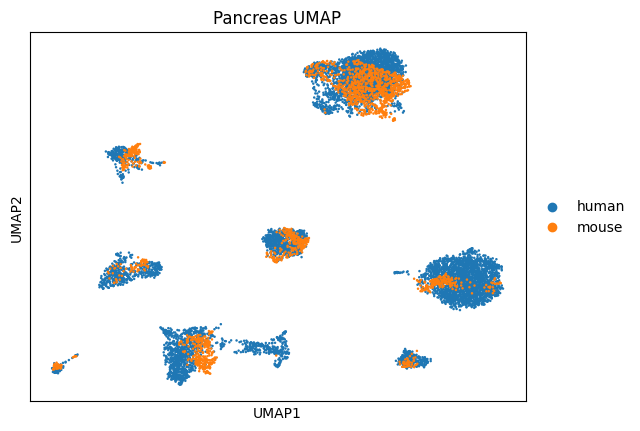

In [18]:
sc.pl.umap(
    orig_adata,
    color="species_label",
    title="Pancreas UMAP",
    show=False,
)
plt.show()
plt.close()

## Visualize Cells

In [19]:
del cell_ot_transport_adata.obsm
del cell_ot_transport_adata.uns
del cell_ot_transport_adata.varm
del cell_ot_transport_adata.obsp

In [20]:
cell_ot_transport_adata

AnnData object with n_obs × n_vars = 500 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label', 'transport', 'split'

In [21]:
sc.tl.pca(cell_ot_transport_adata)
# cell_ot_transport_adata.obsm["X_pca"] = cell_ot_transport_adata.X

In [22]:
cell_ot_transport_adata

AnnData object with n_obs × n_vars = 500 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label', 'transport', 'split'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [23]:
cell_ot_transport_adata.obsm["X_pca"].shape

(500, 49)

In [24]:
sc.pp.neighbors(cell_ot_transport_adata)

In [25]:
sc.tl.umap(cell_ot_transport_adata)

In [26]:
cell_ot_transport_adata

AnnData object with n_obs × n_vars = 500 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label', 'transport', 'split'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [27]:
cell_ot_transport_adata.obs.head()

,cell_barcodes,cell_manual_ids,cell_types,batch_sample,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,species_cell_type_label,species_label,transport,split
human1_lib1.final_cell_0032,AATATCTTC-ATGTTGGC,human1_lib1.final_cell_0032,delta,GSM2230757_human1_umifm_counts,2002,2002,7051.0,0.0,0.0,human_delta,human,source,test
human1_lib1.final_cell_0034,GACACGGACT-CTGAGTGC,human1_lib1.final_cell_0034,delta,GSM2230757_human1_umifm_counts,1698,1698,6475.0,0.0,0.0,human_delta,human,source,test
human1_lib1.final_cell_0041,GTAACGTT-ATGACTTT,human1_lib1.final_cell_0041,activated_stellate,GSM2230757_human1_umifm_counts,3377,3377,12169.0,0.0,0.0,human_activated_stellate,human,source,test
human1_lib1.final_cell_0088,ACTAGATTG-TCCCAATC,human1_lib1.final_cell_0088,beta,GSM2230757_human1_umifm_counts,2069,2068,5979.0,0.0,0.0,human_beta,human,source,test
human1_lib1.final_cell_0135,GAGCGTTGCT-AACACACG,human1_lib1.final_cell_0135,alpha,GSM2230757_human1_umifm_counts,2460,2460,6151.0,0.0,0.0,human_alpha,human,source,test


In [28]:
Counter(cell_ot_transport_adata.obs["species_label"].tolist())

Counter({'human': 500})

In [29]:
Counter(cell_ot_transport_adata.obs["split"].tolist())

Counter({'test': 500})

In [30]:
Counter(cell_ot_transport_adata.obs["transport"].tolist())

Counter({'source': 500})

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


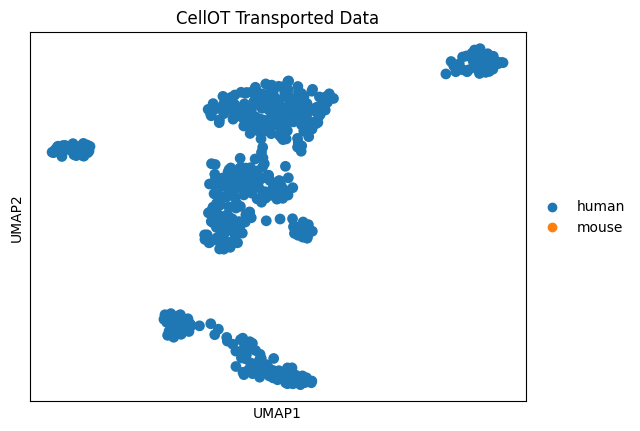

In [31]:
sc.pl.umap(
    cell_ot_transport_adata,
    color="species_label",
    title="CellOT Transported Data",
    show=False,
)
plt.show()
plt.close()

## Combine adatas, see where transported cells are

In [32]:
del orig_adata_reduced.obsm
del orig_adata_reduced.uns
del orig_adata_reduced.varm
del orig_adata_reduced.obsp

In [33]:
del cell_ot_transport_adata.obsm
del cell_ot_transport_adata.uns
del cell_ot_transport_adata.varm
del cell_ot_transport_adata.obsp

In [34]:
orig_adata_reduced

AnnData object with n_obs × n_vars = 9436 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label'

In [35]:
cell_ot_transport_adata

AnnData object with n_obs × n_vars = 500 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label', 'transport', 'split'

In [36]:
orig_data_label = ["Original Data (" + species_label + ")" for species_label in orig_adata_reduced.obs["species_label"]]
orig_adata_reduced.obs["transport_flag"] = orig_data_label
cell_ot_transport_adata.obs["transport_flag"] = "Transported Cells"

In [37]:
combined_adata = orig_adata_reduced.concatenate(cell_ot_transport_adata)
combined_adata

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/anndata/_core/anndata.py:1763: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


AnnData object with n_obs × n_vars = 9936 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label', 'transport_flag', 'transport', 'split', 'batch'

In [38]:
combined_adata

AnnData object with n_obs × n_vars = 9936 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label', 'transport_flag', 'transport', 'split', 'batch'

## Visualize

In [39]:
sc.tl.pca(combined_adata)

In [40]:
sc.pp.neighbors(combined_adata)

In [41]:
sc.tl.umap(combined_adata)

In [42]:
combined_adata

AnnData object with n_obs × n_vars = 9936 × 50
    obs: 'cell_barcodes', 'cell_manual_ids', 'cell_types', 'batch_sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'species_cell_type_label', 'species_label', 'transport_flag', 'transport', 'split', 'batch'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/dor3/.conda/envs/cell2sentence/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


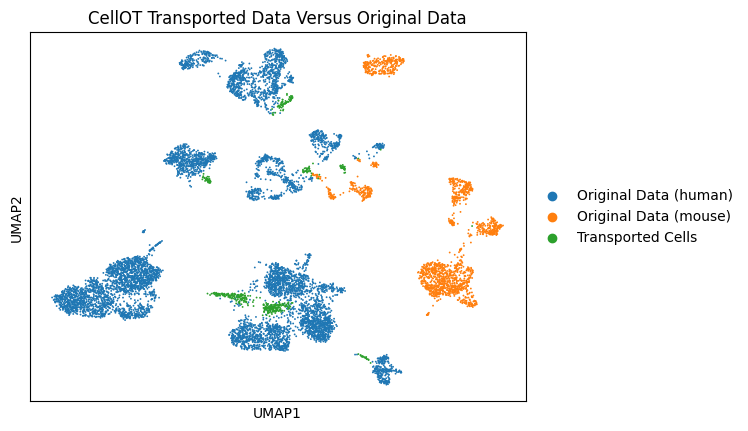

In [44]:
sc.pl.umap(
    combined_adata,
    color="transport_flag",
    title="CellOT Transported Data Versus Original Data",
    show=False,
    s=7
)
save_path = os.path.join("/home/dor3/cell2sentence/cross_species/CellOT_on_Homologous_Data/models/results_human_to_mouse/evals_iid_data_space/plots", "cell_ot_human_transported_vs_orig_data.png")

plt.savefig(save_path, facecolor="white", bbox_inches="tight", dpi=300)
plt.show()
plt.close()